In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm

In [0]:
vgg19 = tf.keras.applications.VGG19(include_top=True,weights = 'imagenet')

In [0]:
def load_img(path):
    max_dim = 512
    
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image,channels = 3)
    
    image = tf.image.convert_image_dtype(image,tf.float32)
    
    shape = tf.cast(tf.shape(image)[:-1],tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim
    
    new_shape = tf.cast(shape*scale,tf.int32)
    image = tf.image.resize(image,new_shape)
    image = image[tf.newaxis,:]
    
    return image

In [0]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [0]:
content_path = 'lss.jpg'
style_path = 'imp.jpg'

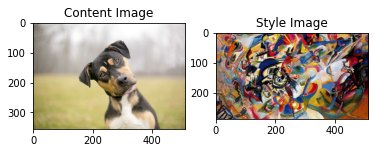

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

In [0]:
def vgg_layers(layer_names):
    vgg  = tf.keras.applications.VGG19(include_top=True,weights = 'imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input],outputs)
    
    return model

In [0]:
def gram_matrix(x):
    result = tf.linalg.einsum("ijkc,ijkd->icd",x,x)
    input_shape = tf.shape(x)
    num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/num_locations

In [0]:
class extract(tf.keras.Model):
    def __init__(self,content_layers,style_layers):
        super(extract,self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.vgg = vgg_layers(style_layers+content_layers)
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self,inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs = outputs[: self.num_style_layers]
        content_outputs = outputs[self.num_style_layers :]

        style_outputs = [gram_matrix(x) for x in style_outputs]
        
        content_dict = {content_name:value for content_name,value in zip(self.content_layers,content_outputs)}
        style_dict = {style_name:value for style_name,value in zip(self.style_layers,style_outputs)}
    
        return {'content':content_dict,'style':style_dict}

In [11]:
extractor = extract(content_layers,style_layers)
style_target = extractor(style_image)['style']
content_target = extractor(content_image)['content']

In [0]:
image = tf.Variable(content_image)

In [0]:
style_weight=1e-2
content_weight=1e4

In [0]:
def compute_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss  = tf.add_n([tf.reduce_mean((style_outputs[name] - style_target[name])**2) for name in style_outputs.keys()])/len(style_outputs)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2) for name in content_outputs.keys()])/len(content_outputs)
    
    loss = style_weight*style_loss + content_weight*content_loss
    
    return loss

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = compute_loss(outputs)
        
    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad,image)])
    image.assign(clip(image))

In [18]:
for i in tqdm(range(1000)):
  train_step(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 500/1000 [47:21<50:24,  6.05s/it]

KeyboardInterrupt: ignored

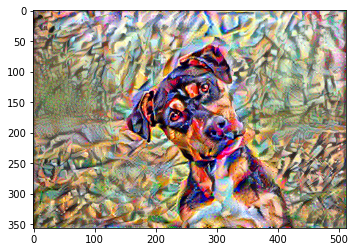

In [19]:
res = ((tf.cast(image,tf.float32)).numpy())[0]
plt.imshow(res)

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
res = tensor_to_image(image)
res.save('generated.jpg')